In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import os

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/dataaa/tuberculosis')

Found 558 files belonging to 2 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
batch = data_iterator.next()

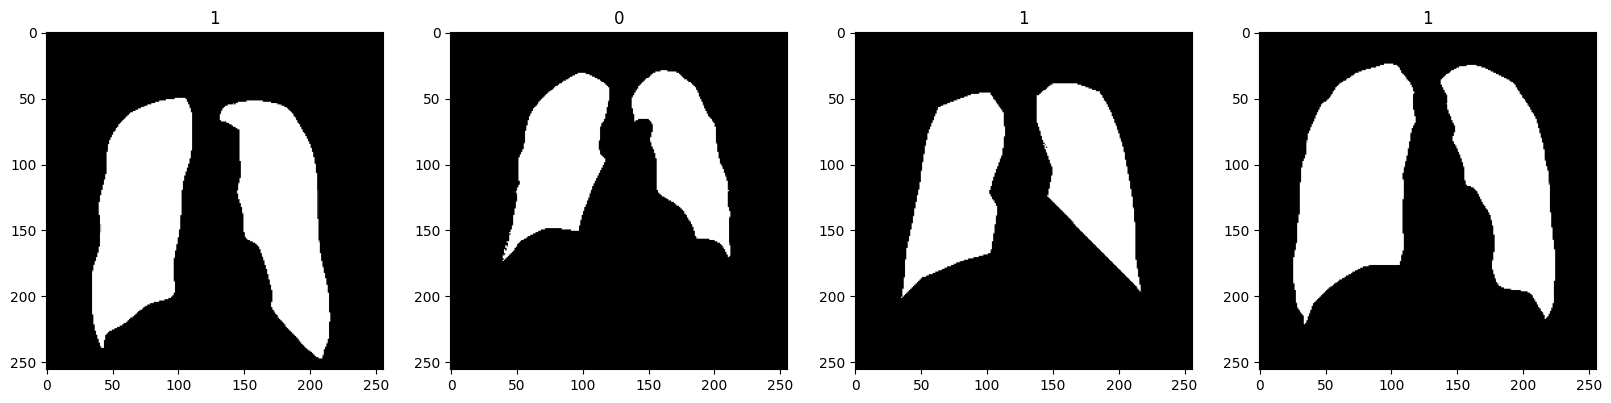

In [ ]:

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
batch[0].min()

0.0

In [ ]:
data = data.map(lambda x,y: (x/255, y))

In [ ]:
data.as_numpy_iterator().next()[0].max()

1.0

In [ ]:
len(data)

18

In [ ]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.3)
test_size = int(len(data)*.1)

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [ ]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

#TSGD Model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Flatten, Dense
from tensorflow.keras import backend as K
import tensorflow as tf

# Assuming 256x256 input images
input_shape = (256, 256, 3)

# Dice coefficient metric
def dice_coefficient(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Jaccard index metric
def jaccard_index(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# Segmentation model
def create_segmentation_model():
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Decoder
    up1 = UpSampling2D(size=(2, 2))(pool1)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up1)

    segmentation_model = Model(inputs, decoded, name='segmentation_model')
    return segmentation_model

# Classification model
def create_classification_model():
    inputs = Input(input_shape)

    # CNN layers
    conv1 = Conv2D(16, (3, 3), activation='relu')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    flatten = Flatten()(pool3)

    # Dense layers
    dense1 = Dense(256, activation='relu')(flatten)
    output = Dense(1, activation='sigmoid')(dense1)

    classification_model = Model(inputs, output, name='classification_model')
    return classification_model

# Combined model
def create_hybrid_model():
    input_tensor = Input(input_shape)

    # Segmentation model
    segmentation_model = create_segmentation_model()
    segmentation_output = segmentation_model(input_tensor)

    # Classification model
    classification_model = create_classification_model()
    classification_output = classification_model(segmentation_output)

    hybrid_model = Model(inputs=input_tensor, outputs=classification_output, name='hybrid_model')
    return hybrid_model

# Compile the hybrid model with additional metrics
hybrid_model = create_hybrid_model()
hybrid_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy', dice_coefficient, jaccard_index])

# Print a summary of the hybrid model architecture
hybrid_model.summary()


Model: "hybrid_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 segmentation_model (Functi  (None, 256, 256, 3)       1763      
 onal)                                                           
                                                                 
 classification_model (Func  (None, 1)                 14769697  
 tional)                                                         
                                                                 
Total params: 14771460 (56.35 MB)
Trainable params: 14771460 (56.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = hybrid_model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
12/12 [==============================] - 140s 10s/step - loss: 1.1881 - accuracy: 0.4818 - dice_coefficient: 0.4737 - jaccard_index: 0.3346 - val_loss: 0.6951 - val_accuracy: 0.5250 - val_dice_coefficient: 0.5551 - val_jaccard_index: 0.3971
Epoch 2/10
12/12 [==============================] - 125s 9s/step - loss: 0.6952 - accuracy: 0.5000 - dice_coefficient: 0.5224 - jaccard_index: 0.3671 - val_loss: 0.6880 - val_accuracy: 0.5312 - val_dice_coefficient: 0.5371 - val_jaccard_index: 0.3798
Epoch 3/10
12/12 [==============================] - 124s 9s/step - loss: 0.6880 - accuracy: 0.5286 - dice_coefficient: 0.5381 - jaccard_index: 0.3813 - val_loss: 0.6776 - val_accuracy: 0.5188 - val_dice_coefficient: 0.4955 - val_jaccard_index: 0.3434
Epoch 4/10
12/12 [==============================] - 136s 10s/step - loss: 0.6723 - accuracy: 0.5573 - dice_coefficient: 0.5081 - jaccard_index: 0.3547 - val_loss: 0.6347 - val_accuracy: 0.6625 - val_dice_coefficient: 0.5117 - val_jaccard_index: 0

In [ ]:
hist = hybrid_model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
12/12 [==============================] - 125s 9s/step - loss: 0.5504 - accuracy: 0.6979 - dice_coefficient: 0.6460 - jaccard_index: 0.4901 - val_loss: 0.5940 - val_accuracy: 0.6687 - val_dice_coefficient: 0.5666 - val_jaccard_index: 0.4125
Epoch 2/10
12/12 [==============================] - 126s 9s/step - loss: 0.5591 - accuracy: 0.7083 - dice_coefficient: 0.6487 - jaccard_index: 0.4933 - val_loss: 0.5214 - val_accuracy: 0.7188 - val_dice_coefficient: 0.6262 - val_jaccard_index: 0.4691
Epoch 3/10
12/12 [==============================] - 135s 10s/step - loss: 0.5486 - accuracy: 0.7396 - dice_coefficient: 0.6438 - jaccard_index: 0.4887 - val_loss: 0.5414 - val_accuracy: 0.7125 - val_dice_coefficient: 0.5975 - val_jaccard_index: 0.4406
Epoch 4/10
12/12 [==============================] - 124s 9s/step - loss: 0.5408 - accuracy: 0.7344 - dice_coefficient: 0.6480 - jaccard_index: 0.4935 - val_loss: 0.5421 - val_accuracy: 0.7125 - val_dice_coefficient: 0.6525 - val_jaccard_index: 0.

In [ ]:
hist = hybrid_model.fit(train, epochs=8, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/8
12/12 [==============================] - 127s 9s/step - loss: 0.3796 - accuracy: 0.8359 - dice_coefficient: 0.7598 - jaccard_index: 0.6231 - val_loss: 0.3978 - val_accuracy: 0.8125 - val_dice_coefficient: 0.7352 - val_jaccard_index: 0.5931
Epoch 2/8
12/12 [==============================] - 124s 9s/step - loss: 0.4050 - accuracy: 0.8281 - dice_coefficient: 0.7481 - jaccard_index: 0.6125 - val_loss: 0.4050 - val_accuracy: 0.7937 - val_dice_coefficient: 0.7747 - val_jaccard_index: 0.6428
Epoch 3/8
12/12 [==============================] - 123s 9s/step - loss: 0.3407 - accuracy: 0.8490 - dice_coefficient: 0.7727 - jaccard_index: 0.6396 - val_loss: 0.3291 - val_accuracy: 0.8562 - val_dice_coefficient: 0.7848 - val_jaccard_index: 0.6577
Epoch 4/8
12/12 [==============================] - 135s 10s/step - loss: 0.3014 - accuracy: 0.8750 - dice_coefficient: 0.8185 - jaccard_index: 0.7030 - val_loss: 0.3609 - val_accuracy: 0.8625 - val_dice_coefficient: 0.8011 - val_jaccard_index: 0.6780

In [ ]:
hist = hybrid_model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
12/12 [==============================] - 128s 9s/step - loss: 0.2089 - accuracy: 0.8984 - dice_coefficient: 0.8562 - jaccard_index: 0.7596 - val_loss: 0.2115 - val_accuracy: 0.9000 - val_dice_coefficient: 0.8393 - val_jaccard_index: 0.7323
Epoch 2/10
12/12 [==============================] - 126s 9s/step - loss: 0.1876 - accuracy: 0.9271 - dice_coefficient: 0.8663 - jaccard_index: 0.7719 - val_loss: 0.1651 - val_accuracy: 0.9375 - val_dice_coefficient: 0.8902 - val_jaccard_index: 0.8080
Epoch 3/10
12/12 [==============================] - 138s 11s/step - loss: 0.1114 - accuracy: 0.9688 - dice_coefficient: 0.9197 - jaccard_index: 0.8566 - val_loss: 0.1475 - val_accuracy: 0.9625 - val_dice_coefficient: 0.8953 - val_jaccard_index: 0.8168
Epoch 4/10
12/12 [==============================] - 131s 10s/step - loss: 0.1025 - accuracy: 0.9714 - dice_coefficient: 0.9317 - jaccard_index: 0.8773 - val_loss: 0.1648 - val_accuracy: 0.9500 - val_dice_coefficient: 0.9262 - val_jaccard_index: 0

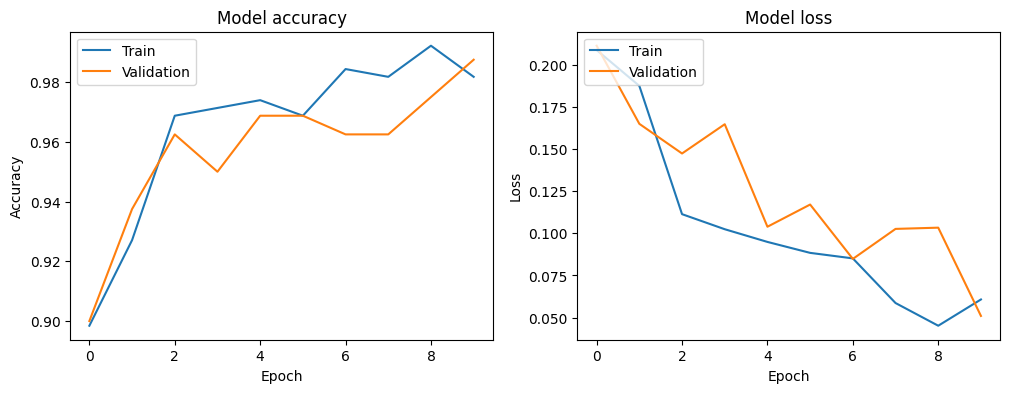

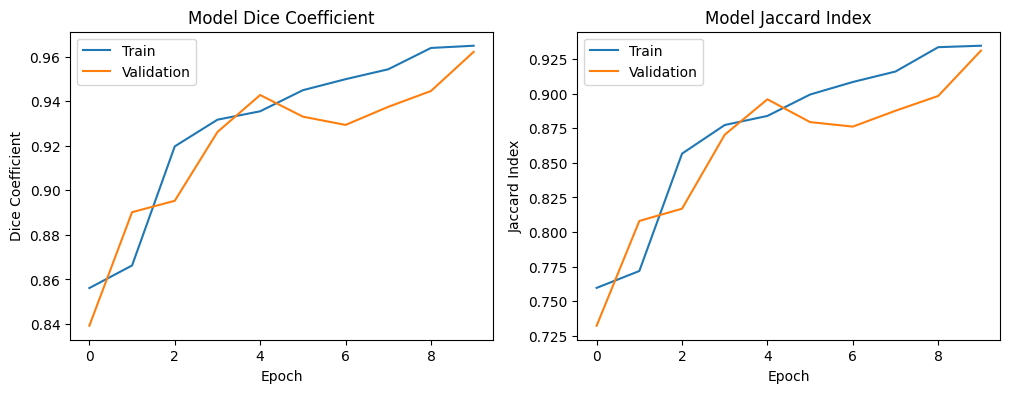

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Plot Dice coefficient values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist.history['dice_coefficient'])
plt.plot(hist.history['val_dice_coefficient'])
plt.title('Model Dice Coefficient')
plt.ylabel('Dice Coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot Jaccard index values
plt.subplot(1, 2, 2)
plt.plot(hist.history['jaccard_index'])
plt.plot(hist.history['val_jaccard_index'])
plt.title('Model Jaccard Index')
plt.ylabel('Jaccard Index')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import Model
import numpy as np

# Calculate Dice coefficient
def dice_coefficient(y_true, y_pred):
    smooth = 1.0
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

# Calculate Jaccard index
def jaccard_index(y_true, y_pred):
    smooth = 1.0
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

pre = Precision()
re = Recall()
acc = BinaryAccuracy()
dice = []
jaccard = []

for batch in val.as_numpy_iterator():
    X, y = batch
    yhat = hybrid_model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    dice.append(dice_coefficient(y, yhat))
    jaccard.append(jaccard_index(y, yhat))

precision = pre.result().numpy()
recall = re.result().numpy()
accuracy = acc.result().numpy()
mean_dice = np.mean(dice)
mean_jaccard = np.mean(jaccard)

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1 Score:", f1_score)
print("Mean Dice Coefficient:", mean_dice)
print("Mean Jaccard Index:", mean_jaccard)


1/1 [==============================] - 2s 2s/step
Precision: 0.974359
Recall: 1.0
Accuracy: 0.9875
F1 Score: 0.9870129579998315
Mean Dice Coefficient: 0.9750687466819417
Mean Jaccard Index: 0.9533330248953806


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have loaded the data correctly and the shapes are compatible
# Get true labels for the validation set
true_labels = np.concatenate([y for x, y in val], axis=0)

# Predict labels using the hybrid model on the validation set
predicted_labels = hybrid_model.predict(val)

# Convert predicted probabilities to binary labels
predicted_labels_binary = np.round(predicted_labels).astype(int)

print("Shape of true labels:", true_labels.shape)
print("Shape of predicted labels:", predicted_labels_binary.shape)


5/5 [==============================] - 31s 2s/step
Shape of true labels: (160,)
Shape of predicted labels: (160, 1)


5/5 [==============================] - 29s 2s/step


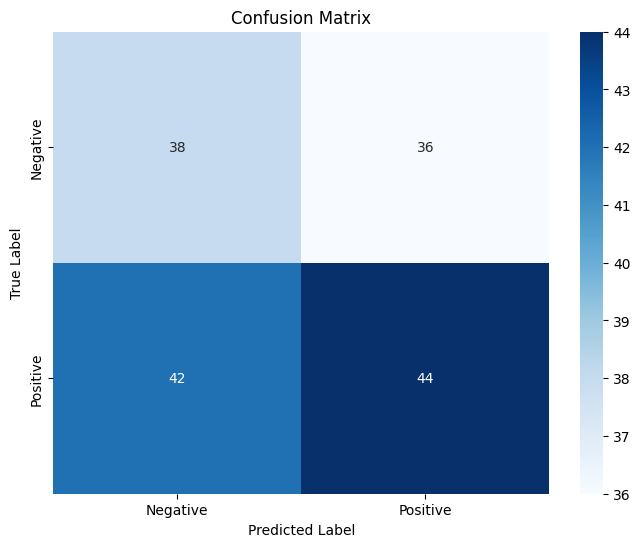

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have loaded the data correctly and the shapes are compatible
# Get true labels for the validation set
true_labels = np.concatenate([y for x, y in val], axis=0)

# Predict labels using the hybrid model on the validation set
predicted_labels = hybrid_model.predict(val)

# Flatten the predicted labels array
predicted_labels_flat = np.round(predicted_labels).astype(int).flatten()

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels_flat)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


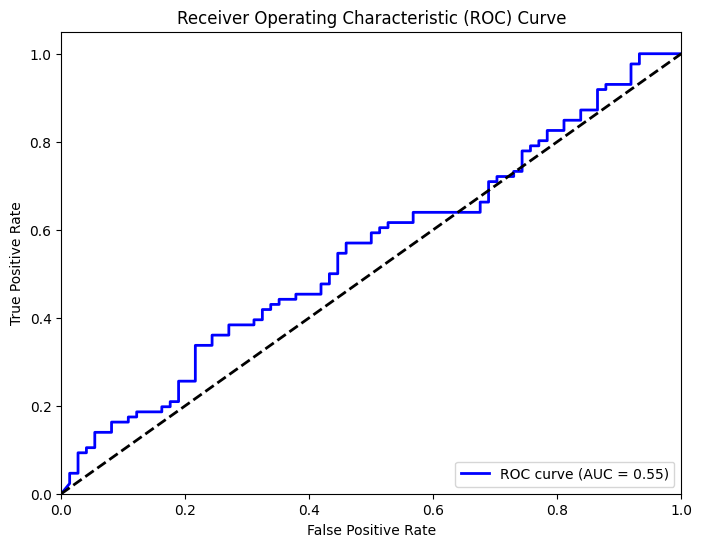

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have true labels and predicted probabilities
# true_labels: True labels for the validation set
# predicted_probs: Predicted probabilities for the positive class

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)

# Calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


#BN-CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import backend as K

# Define Dice coefficient metric
def dice_coefficient(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Define Jaccard index metric
def jaccard_index(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# Create a Sequential model
model = Sequential()

# Add convolutional layers with batch normalization and max pooling
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add dropout
model.add(Dropout(0.25))

# Flatten the output
model.add(Flatten())

# Add dense layers with batch normalization and dropout
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', dice_coefficient, jaccard_index])

# Print a summary of the model architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 16)      0         
                                                                 
 flatten (Flatten)           (None, 258064)            0         
                                                                 
 dense (Dense)               (None, 32)                8

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
12/12 [==============================] - 79s 6s/step - loss: 0.8167 - accuracy: 0.6536 - dice_coefficient: 0.6270 - jaccard_index: 0.4724 - val_loss: 1.0473 - val_accuracy: 0.6125 - val_dice_coefficient: 0.7138 - val_jaccard_index: 0.5655
Epoch 2/10
12/12 [==============================] - 61s 4s/step - loss: 0.5489 - accuracy: 0.7604 - dice_coefficient: 0.6709 - jaccard_index: 0.5173 - val_loss: 0.6940 - val_accuracy: 0.5688 - val_dice_coefficient: 0.6371 - val_jaccard_index: 0.4800
Epoch 3/10
12/12 [==============================] - 60s 4s/step - loss: 0.5522 - accuracy: 0.7344 - dice_coefficient: 0.6614 - jaccard_index: 0.5070 - val_loss: 0.5934 - val_accuracy: 0.6938 - val_dice_coefficient: 0.6149 - val_jaccard_index: 0.4561
Epoch 4/10
12/12 [==============================] - 60s 4s/step - loss: 0.4458 - accuracy: 0.8203 - dice_coefficient: 0.7075 - jaccard_index: 0.5597 - val_loss: 0.6153 - val_accuracy: 0.6875 - val_dice_coefficient: 0.5446 - val_jaccard_index: 0.3883


In [ ]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
12/12 [==============================] - 82s 6s/step - loss: 0.0990 - accuracy: 0.9661 - dice_coefficient: 0.9216 - jaccard_index: 0.8601 - val_loss: 0.4590 - val_accuracy: 0.7875 - val_dice_coefficient: 0.6934 - val_jaccard_index: 0.5419
Epoch 2/10
12/12 [==============================] - 58s 4s/step - loss: 0.0824 - accuracy: 0.9896 - dice_coefficient: 0.9303 - jaccard_index: 0.8742 - val_loss: 0.4692 - val_accuracy: 0.7437 - val_dice_coefficient: 0.7159 - val_jaccard_index: 0.5681
Epoch 3/10
12/12 [==============================] - 59s 4s/step - loss: 0.0398 - accuracy: 0.9974 - dice_coefficient: 0.9643 - jaccard_index: 0.9332 - val_loss: 0.4267 - val_accuracy: 0.8125 - val_dice_coefficient: 0.7243 - val_jaccard_index: 0.5768
Epoch 4/10
12/12 [==============================] - 59s 4s/step - loss: 0.0477 - accuracy: 0.9922 - dice_coefficient: 0.9598 - jaccard_index: 0.9250 - val_loss: 0.4293 - val_accuracy: 0.8375 - val_dice_coefficient: 0.6897 - val_jaccard_index: 0.5398


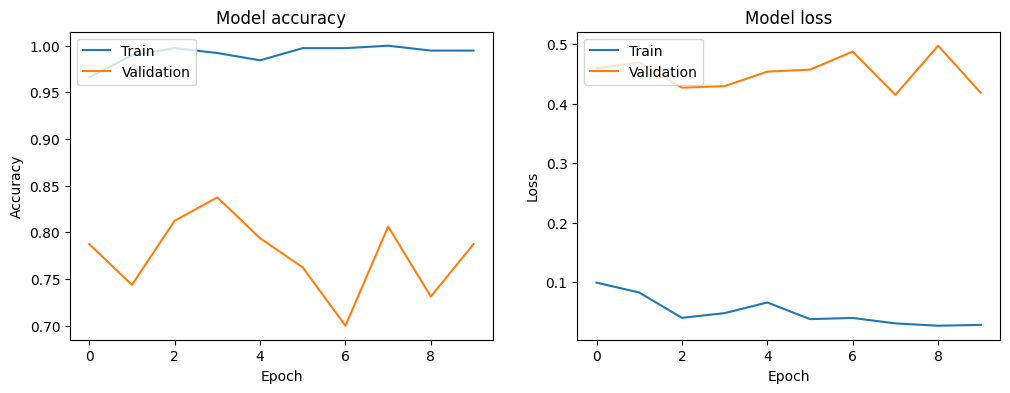

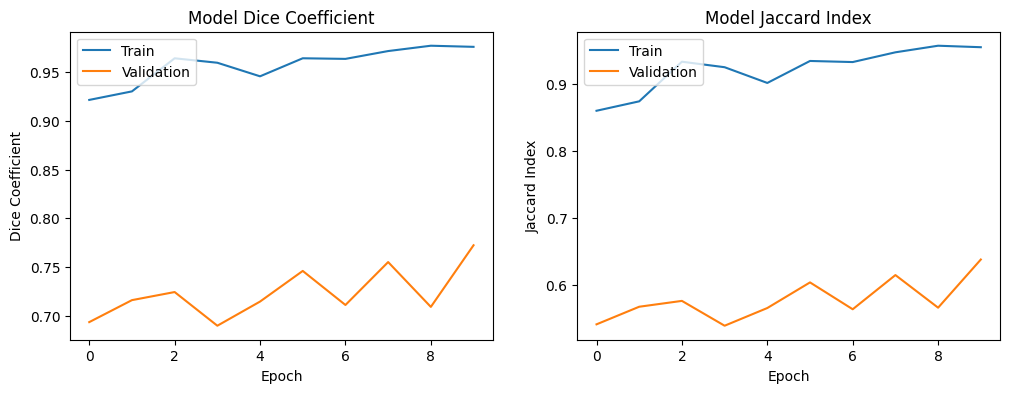

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Plot Dice coefficient values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist.history['dice_coefficient'])
plt.plot(hist.history['val_dice_coefficient'])
plt.title('Model Dice Coefficient')
plt.ylabel('Dice Coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot Jaccard index values
plt.subplot(1, 2, 2)
plt.plot(hist.history['jaccard_index'])
plt.plot(hist.history['val_jaccard_index'])
plt.title('Model Jaccard Index')
plt.ylabel('Jaccard Index')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import Model
import numpy as np

# Calculate Dice coefficient
def dice_coefficient(y_true, y_pred):
    smooth = 1.0
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

# Calculate Jaccard index
def jaccard_index(y_true, y_pred):
    smooth = 1.0
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

pre = Precision()
re = Recall()
acc = BinaryAccuracy()
dice = []
jaccard = []

for batch in val.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    dice.append(dice_coefficient(y, yhat))
    jaccard.append(jaccard_index(y, yhat))

precision = pre.result().numpy()
recall = re.result().numpy()
accuracy = acc.result().numpy()
mean_dice = np.mean(dice)
mean_jaccard = np.mean(jaccard)

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1 Score:", f1_score)
print("Mean Dice Coefficient:", mean_dice)
print("Mean Jaccard Index:", mean_jaccard)


1/1 [==============================] - 0s 418ms/step
Precision: 0.7355372
Recall: 1.0
Accuracy: 0.8
F1 Score: 0.8476190351899248
Mean Dice Coefficient: 0.780190689879864
Mean Jaccard Index: 0.6528663312323849


5/5 [==============================] - 24s 577ms/step


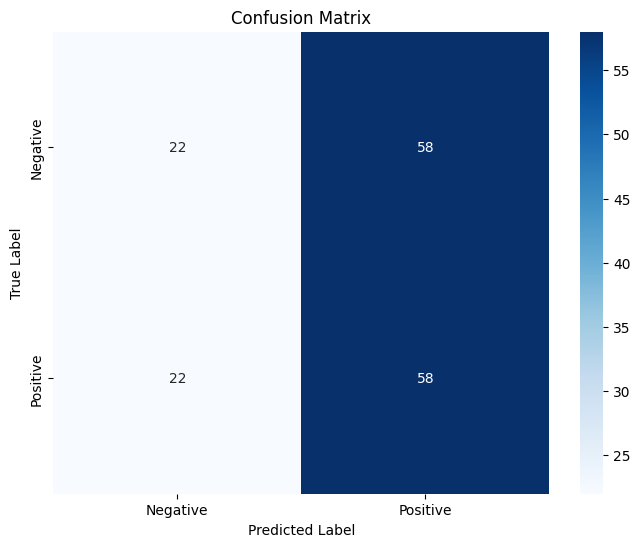

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have loaded the data correctly and the shapes are compatible
# Get true labels for the validation set
true_labels = np.concatenate([y for x, y in val], axis=0)

# Predict labels using the hybrid model on the validation set
predicted_labels = model.predict(val)

# Flatten the predicted labels array
predicted_labels_flat = np.round(predicted_labels).astype(int).flatten()

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels_flat)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


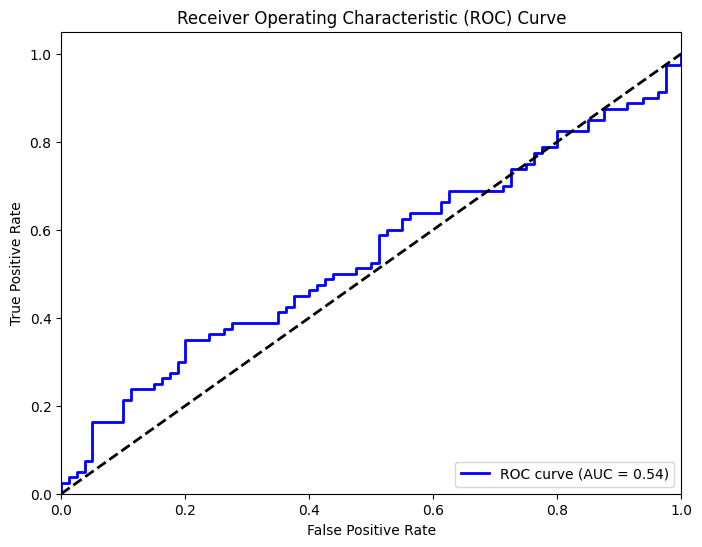

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have true labels and predicted probabilities
# true_labels: True labels for the validation set
# predicted_probs: Predicted probabilities for the positive class

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)

# Calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


#Basic CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# Define Dice coefficient metric
def dice_coefficient(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Define Jaccard index metric
def jaccard_index(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# Create the Sequential model
model = Sequential([
    Conv2D(16, (3, 3), activation='tanh', input_shape=(256, 256, 3)),
    Conv2D(32, (3, 3), activation='tanh'),
    Conv2D(16, (3, 3), activation='tanh'),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='sigmoid'),
    Dense(1, activation='sigmoid')
])

# Compile the model with custom metrics
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy', dice_coefficient, jaccard_index])

# Print a summary of the model architecture
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 conv2d_2 (Conv2D)           (None, 252, 252, 32)      4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 250, 250, 16)      4624      
                                                                 
 flatten_1 (Flatten)         (None, 1000000)           0         
                                                                 
 dropout_2 (Dropout)         (None, 1000000)           0         
                                                                 
 dense_2 (Dense)             (None, 128)               128000128 
                                                                 
 dense_3 (Dense)             (None, 1)                

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
12/12 [==============================] - 153s 11s/step - loss: 2.4784 - accuracy: 0.5078 - dice_coefficient: 0.1158 - jaccard_index: 0.0984 - val_loss: 2.5757 - val_accuracy: 0.4812 - val_dice_coefficient: 0.0706 - val_jaccard_index: 0.0645
Epoch 2/10
12/12 [==============================] - 149s 11s/step - loss: 1.6421 - accuracy: 0.4974 - dice_coefficient: 0.2481 - jaccard_index: 0.1798 - val_loss: 0.9447 - val_accuracy: 0.4250 - val_dice_coefficient: 0.3581 - val_jaccard_index: 0.2359
Epoch 3/10
12/12 [==============================] - 143s 11s/step - loss: 0.7650 - accuracy: 0.5104 - dice_coefficient: 0.3943 - jaccard_index: 0.2642 - val_loss: 0.7352 - val_accuracy: 0.4750 - val_dice_coefficient: 0.4432 - val_jaccard_index: 0.3014
Epoch 4/10
12/12 [==============================] - 146s 11s/step - loss: 0.6891 - accuracy: 0.4896 - dice_coefficient: 0.4753 - jaccard_index: 0.3281 - val_loss: 0.6767 - val_accuracy: 0.5000 - val_dice_coefficient: 0.5018 - val_jaccard_index:

In [ ]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
12/12 [==============================] - 154s 11s/step - loss: 0.6947 - accuracy: 0.4609 - dice_coefficient: 0.5121 - jaccard_index: 0.3583 - val_loss: 0.6944 - val_accuracy: 0.4688 - val_dice_coefficient: 0.5226 - val_jaccard_index: 0.3672
Epoch 2/10
12/12 [==============================] - 147s 11s/step - loss: 0.6935 - accuracy: 0.4948 - dice_coefficient: 0.5207 - jaccard_index: 0.3650 - val_loss: 0.6907 - val_accuracy: 0.5562 - val_dice_coefficient: 0.5441 - val_jaccard_index: 0.3865
Epoch 3/10
12/12 [==============================] - 143s 11s/step - loss: 0.6940 - accuracy: 0.4948 - dice_coefficient: 0.5136 - jaccard_index: 0.3594 - val_loss: 0.6928 - val_accuracy: 0.5250 - val_dice_coefficient: 0.5270 - val_jaccard_index: 0.3708
Epoch 4/10
12/12 [==============================] - 146s 11s/step - loss: 0.6939 - accuracy: 0.5052 - dice_coefficient: 0.5146 - jaccard_index: 0.3610 - val_loss: 0.6932 - val_accuracy: 0.4812 - val_dice_coefficient: 0.5013 - val_jaccard_index:

In [ ]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
12/12 [==============================] - 152s 11s/step - loss: 0.6952 - accuracy: 0.5052 - dice_coefficient: 0.5246 - jaccard_index: 0.3696 - val_loss: 0.6943 - val_accuracy: 0.4875 - val_dice_coefficient: 0.5148 - val_jaccard_index: 0.3600
Epoch 2/10
12/12 [==============================] - 147s 11s/step - loss: 0.6935 - accuracy: 0.5052 - dice_coefficient: 0.5193 - jaccard_index: 0.3649 - val_loss: 0.6910 - val_accuracy: 0.5813 - val_dice_coefficient: 0.5501 - val_jaccard_index: 0.3925
Epoch 3/10
12/12 [==============================] - 147s 11s/step - loss: 0.6934 - accuracy: 0.5026 - dice_coefficient: 0.5159 - jaccard_index: 0.3619 - val_loss: 0.6926 - val_accuracy: 0.5250 - val_dice_coefficient: 0.5277 - val_jaccard_index: 0.3717
Epoch 4/10
12/12 [==============================] - 159s 12s/step - loss: 0.6952 - accuracy: 0.4661 - dice_coefficient: 0.5016 - jaccard_index: 0.3491 - val_loss: 0.6934 - val_accuracy: 0.5063 - val_dice_coefficient: 0.5010 - val_jaccard_index:

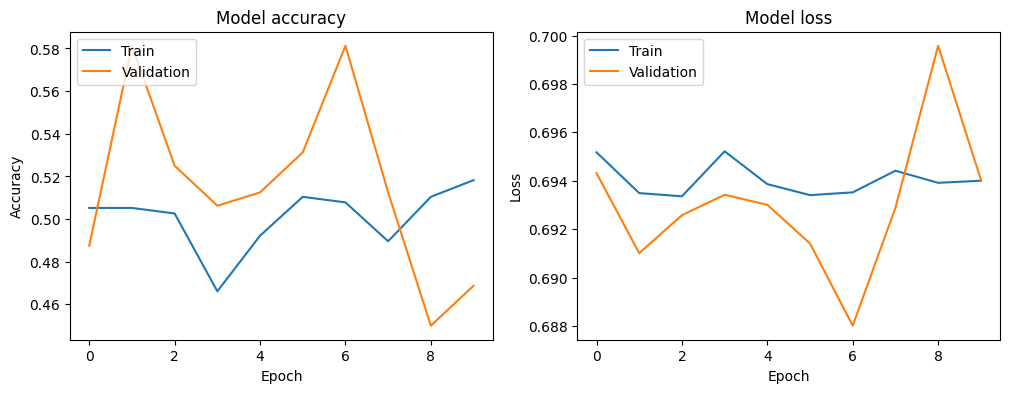

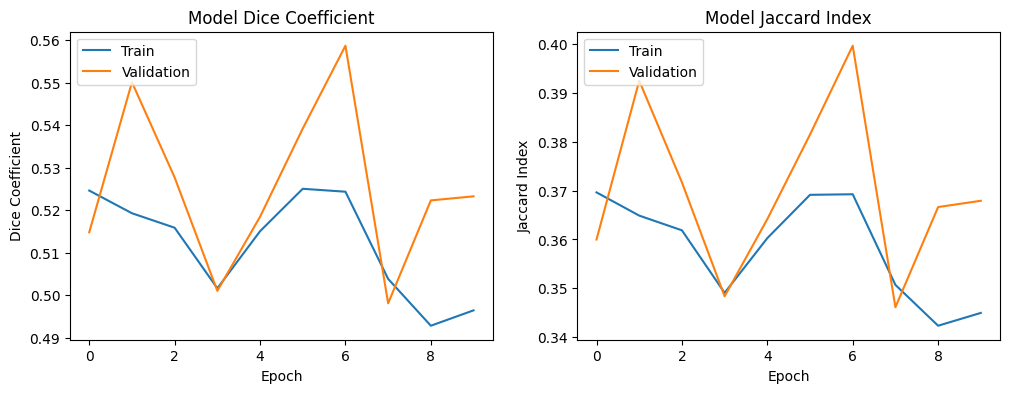

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Plot Dice coefficient values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist.history['dice_coefficient'])
plt.plot(hist.history['val_dice_coefficient'])
plt.title('Model Dice Coefficient')
plt.ylabel('Dice Coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot Jaccard index values
plt.subplot(1, 2, 2)
plt.plot(hist.history['jaccard_index'])
plt.plot(hist.history['val_jaccard_index'])
plt.title('Model Jaccard Index')
plt.ylabel('Jaccard Index')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import Model
import numpy as np

# Calculate Dice coefficient
def dice_coefficient(y_true, y_pred):
    smooth = 1.0
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

# Calculate Jaccard index
def jaccard_index(y_true, y_pred):
    smooth = 1.0
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

pre = Precision()
re = Recall()
acc = BinaryAccuracy()
dice = []
jaccard = []

for batch in val.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    dice.append(dice_coefficient(y, yhat))
    jaccard.append(jaccard_index(y, yhat))

precision = pre.result().numpy()
recall = re.result().numpy()
accuracy = acc.result().numpy()
mean_dice = np.mean(dice)
mean_jaccard = np.mean(jaccard)

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1 Score:", f1_score)
print("Mean Dice Coefficient:", mean_dice)
print("Mean Jaccard Index:", mean_jaccard)


1/1 [==============================] - 2s 2s/step
Precision: 0.0
Recall: 0.0
Accuracy: 0.525
F1 Score: nan
Mean Dice Coefficient: 0.49728904598285917
Mean Jaccard Index: 0.34546446976478035


<ipython-input-31-81536db11e97>:44: RuntimeWarning: invalid value encountered in scalar divide
  f1_score = 2 * (precision * recall) / (precision + recall)


5/5 [==============================] - 29s 2s/step


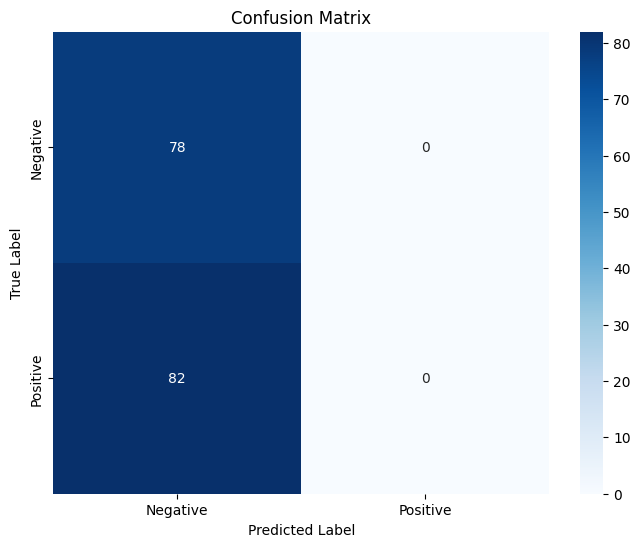

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get true labels for the validation set
true_labels = np.concatenate([y for x, y in val], axis=0)

# Predict labels using the hybrid model on the validation set
predicted_labels = model.predict(val)

# Convert predicted probabilities to binary labels
predicted_labels_binary = np.round(predicted_labels).astype(int)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


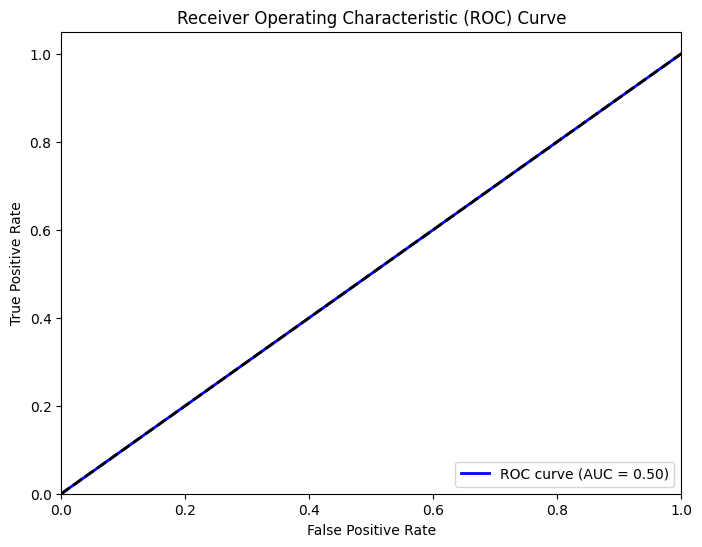

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have true labels and predicted probabilities
# true_labels: True labels for the validation set
# predicted_probs: Predicted probabilities for the positive class

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)

# Calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


#Deep CNN

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# Assuming 256x256 input images
input_shape = (256, 256, 3)

# Define Dice coefficient metric
def dice_coefficient(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Define Jaccard index metric
def jaccard_index(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def create_simple_cnn_classification_model_with_high_dropout():
    inputs = Input(input_shape)

    # Simple CNN layers
    conv1 = Conv2D(8, (3, 3), activation='relu')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    flatten = Flatten()(pool1)

    # Dense layers with high dropout
    dense1 = Dense(16, activation='relu')(flatten)
    dropout1 = Dropout(0.8)(dense1)  # Increase dropout rate to 0.8
    output = Dense(1, activation='sigmoid')(dropout1)

    simple_cnn_classification_model_with_high_dropout = Model(inputs, output, name='simple_cnn_classification_model_with_high_dropout')
    return simple_cnn_classification_model_with_high_dropout

# Create the model with high dropout
model_with_high_dropout = create_simple_cnn_classification_model_with_high_dropout()

# Compile the model with custom metrics
model_with_high_dropout.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy', dice_coefficient, jaccard_index])


In [ ]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model_with_high_dropout.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/5
12/12 [==============================] - 72s 5s/step - loss: 2.2611 - accuracy: 0.5286 - dice_coefficient: 0.5159 - jaccard_index: 0.3649 - val_loss: 0.6927 - val_accuracy: 0.5250 - val_dice_coefficient: 0.5022 - val_jaccard_index: 0.3490
Epoch 2/5
12/12 [==============================] - 50s 3s/step - loss: 0.6931 - accuracy: 0.5130 - dice_coefficient: 0.5027 - jaccard_index: 0.3511 - val_loss: 0.6932 - val_accuracy: 0.4938 - val_dice_coefficient: 0.5122 - val_jaccard_index: 0.3590
Epoch 3/5
12/12 [==============================] - 51s 4s/step - loss: 0.6931 - accuracy: 0.5130 - dice_coefficient: 0.5074 - jaccard_index: 0.3536 - val_loss: 0.6934 - val_accuracy: 0.4500 - val_dice_coefficient: 0.5347 - val_jaccard_index: 0.3779
Epoch 4/5
12/12 [==============================] - 68s 5s/step - loss: 0.6933 - accuracy: 0.4766 - dice_coefficient: 0.5212 - jaccard_index: 0.3664 - val_loss: 0.6931 - val_accuracy: 0.4688 - val_dice_coefficient: 0.5280 - val_jaccard_index: 0.3715
Epoc

In [ ]:
hist = model_with_high_dropout.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
12/12 [==============================] - 49s 3s/step - loss: 0.6932 - accuracy: 0.5208 - dice_coefficient: 0.5015 - jaccard_index: 0.3491 - val_loss: 0.6934 - val_accuracy: 0.4688 - val_dice_coefficient: 0.5255 - val_jaccard_index: 0.3700
Epoch 2/10
12/12 [==============================] - 50s 3s/step - loss: 0.6932 - accuracy: 0.4948 - dice_coefficient: 0.5127 - jaccard_index: 0.3591 - val_loss: 0.6933 - val_accuracy: 0.4812 - val_dice_coefficient: 0.5189 - val_jaccard_index: 0.3645
Epoch 3/10
12/12 [==============================] - 48s 3s/step - loss: 0.6932 - accuracy: 0.4896 - dice_coefficient: 0.5173 - jaccard_index: 0.3625 - val_loss: 0.6931 - val_accuracy: 0.5125 - val_dice_coefficient: 0.5054 - val_jaccard_index: 0.3524
Epoch 4/10
12/12 [==============================] - 48s 3s/step - loss: 0.6931 - accuracy: 0.5104 - dice_coefficient: 0.5073 - jaccard_index: 0.3539 - val_loss: 0.6934 - val_accuracy: 0.4500 - val_dice_coefficient: 0.5346 - val_jaccard_index: 0.3779


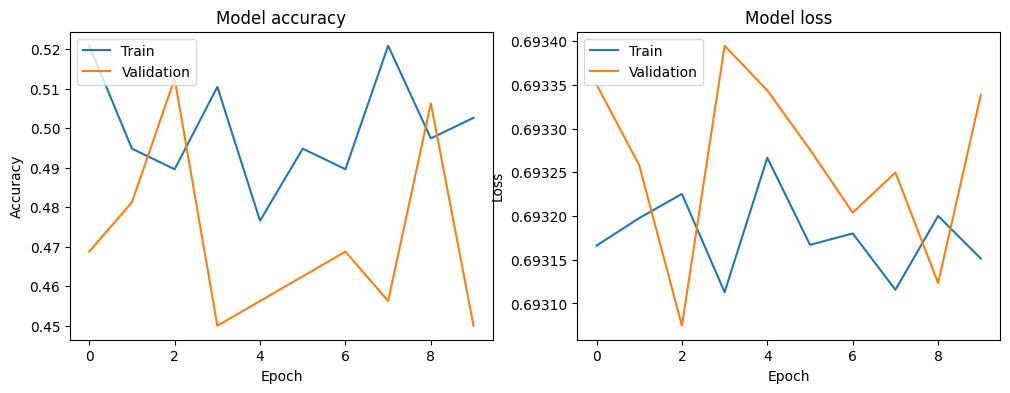

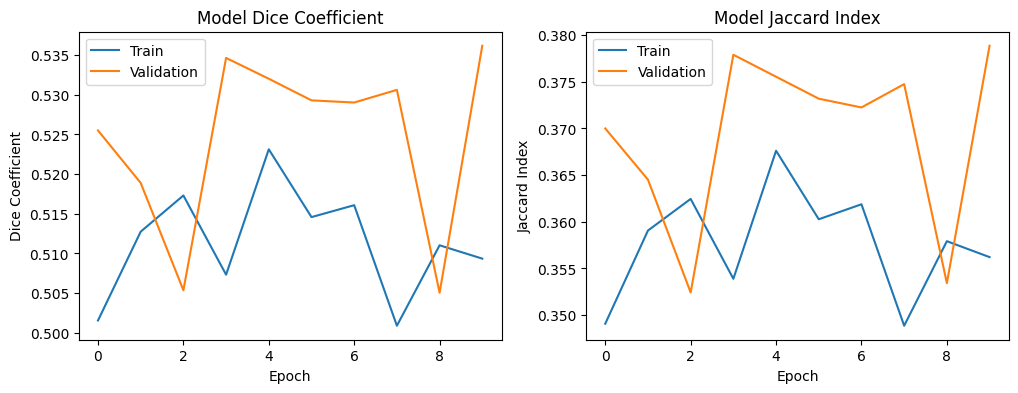

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Plot Dice coefficient values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist.history['dice_coefficient'])
plt.plot(hist.history['val_dice_coefficient'])
plt.title('Model Dice Coefficient')
plt.ylabel('Dice Coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot Jaccard index values
plt.subplot(1, 2, 2)
plt.plot(hist.history['jaccard_index'])
plt.plot(hist.history['val_jaccard_index'])
plt.title('Model Jaccard Index')
plt.ylabel('Jaccard Index')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import Model
import numpy as np

# Calculate Dice coefficient
def dice_coefficient(y_true, y_pred):
    smooth = 1.0
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

# Calculate Jaccard index
def jaccard_index(y_true, y_pred):
    smooth = 1.0
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

pre = Precision()
re = Recall()
acc = BinaryAccuracy()
dice = []
jaccard = []

for batch in val.as_numpy_iterator():
    X, y = batch
    yhat = model_with_high_dropout.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    dice.append(dice_coefficient(y, yhat))
    jaccard.append(jaccard_index(y, yhat))

precision = pre.result().numpy()
recall = re.result().numpy()
accuracy = acc.result().numpy()
mean_dice = np.mean(dice)
mean_jaccard = np.mean(jaccard)

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)

# print("Precision:", precision)
# print("Recall:", recall)
print("Accuracy:", accuracy)
# print("F1 Score:", f1_score)
print("Mean Dice Coefficient:", mean_dice)
print("Mean Jaccard Index:", mean_jaccard)


1/1 [==============================] - 0s 426ms/step
Accuracy: 0.48125
Mean Dice Coefficient: 0.5229020956607637
Mean Jaccard Index: 0.36691982542975093


<ipython-input-41-8fb9f9c31f06>:44: RuntimeWarning: invalid value encountered in scalar divide
  f1_score = 2 * (precision * recall) / (precision + recall)


5/5 [==============================] - 22s 348ms/step


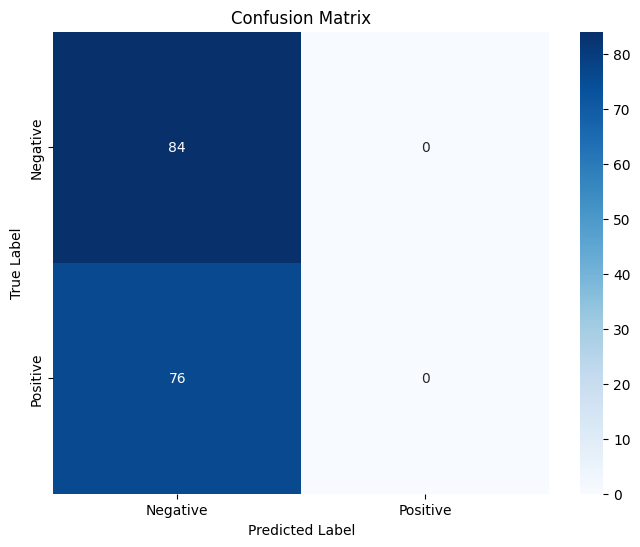

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get true labels for the validation set
true_labels = np.concatenate([y for x, y in val], axis=0)

# Predict labels using the hybrid model on the validation set
predicted_labels = model_with_high_dropout.predict(val)

# Convert predicted probabilities to binary labels
predicted_labels_binary = np.round(predicted_labels).astype(int)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


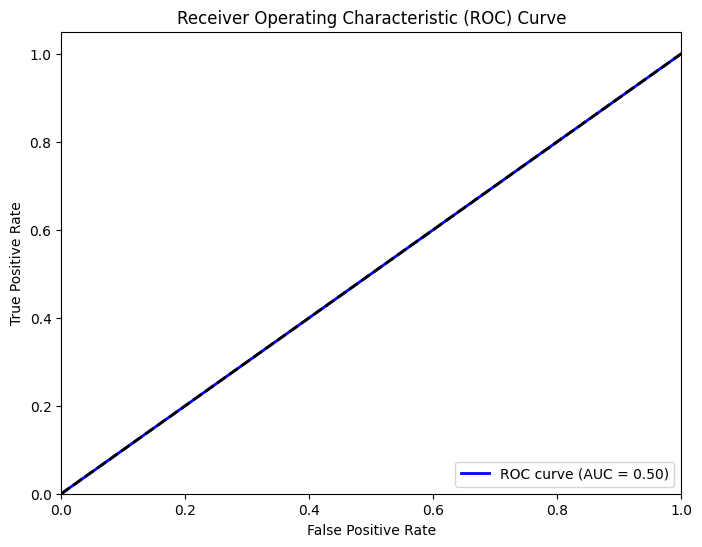

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have true labels and predicted probabilities
# true_labels: True labels for the validation set
# predicted_probs: Predicted probabilities for the positive class

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)

# Calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
